In [20]:
from torchvision import transforms
from PIL import Image

import pytorch_lightning as pl
from transformers import DetrConfig, DetrForObjectDetection
import torch

class Detr(pl.LightningModule):

     def __init__(self, lr, lr_backbone, weight_decay):
         super().__init__()
         # замените head классификации COCO на кастомную
         self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", 
                                                             num_labels=len(id2label),
                                                             ignore_mismatched_sizes=True)
         # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
         self.lr = lr
         self.lr_backbone = lr_backbone
         self.weight_decay = weight_decay

     def forward(self, pixel_values, pixel_mask=None):
       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

       return outputs
     
     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       pixel_mask = batch["pixel_mask"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
          self.log("train_" + k, v.item())

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
          self.log("validation_" + k, v.item())

        return loss

     def configure_optimizers(self):
        param_dicts = [
              {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
              {
                  "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                  "lr": self.lr_backbone,
              },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                  weight_decay=self.weight_decay)
        
        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader

In [21]:
import torch
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{id2label[cl.item()]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()


def visualize_predictions(image, outputs, threshold=0.6):
  # keep only predictions with confidence >= threshold
  probas = outputs.logits.softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold
  
  # convert predicted boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)

  # plot results
  plot_results(image, probas[keep], bboxes_scaled)

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([6, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([6, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably

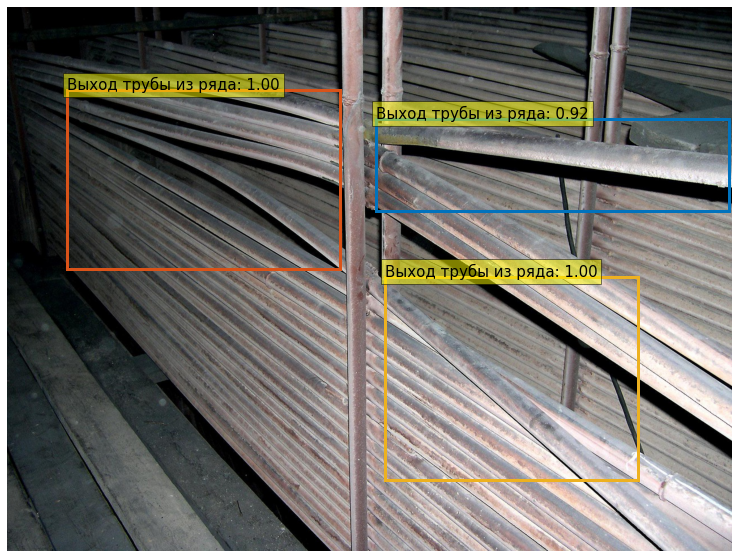

In [22]:
device = 'cpu'
id2label = {0: 'Выход трубы из ряда', 1: 'Крип', 2: 'Разрыв', 3: 'Свищ', 4: 'Трещина'}
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)
model = model.load_from_checkpoint('checkpoints/epoch=449-step=352800.ckpt', lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)
model.eval()
image = Image.open('img/4.jpg').convert('RGB')
convert_tensor = transforms.ToTensor()

tensor_image = convert_tensor(image).unsqueeze_(0)
outputs = model(pixel_values=tensor_image, pixel_mask=None)
visualize_predictions(image, outputs)

In [44]:
outputs

DetrObjectDetectionOutput(loss=None, loss_dict=None, logits=tensor([[[-3.2305e+00, -9.1621e+00, -4.1607e+00, -6.6381e+00, -6.0116e+00,
           9.7206e+00],
         [-1.4040e+00, -4.9617e+00, -4.3341e+00, -8.1732e+00, -4.4488e+00,
           7.9374e+00],
         [-3.3514e+00, -9.7123e+00, -5.6610e+00, -7.1745e+00, -7.0366e+00,
           1.1727e+01],
         [-2.7946e+00, -6.9197e+00, -6.2969e+00, -6.1730e+00, -3.4427e+00,
           8.7704e+00],
         [ 1.6530e+00, -6.1272e+00, -4.1366e+00, -1.3580e+01, -2.6786e+00,
           7.0167e+00],
         [-4.3550e-01, -3.3005e-01, -9.6112e+00, -1.0953e+01, -7.1555e+00,
           9.4603e+00],
         [-2.5266e+00, -2.1045e+00, -9.1093e+00, -1.0653e+01, -8.3161e+00,
           1.1535e+01],
         [-1.9423e+00, -7.7921e+00, -5.9232e+00, -1.1660e+01, -1.2457e+00,
           9.4298e+00],
         [ 5.2902e-01, -5.3627e+00, -5.5692e+00, -1.3751e+01, -5.0448e+00,
           9.2766e+00],
         [-2.2511e+00, -1.0767e+01, -6.4231e+00, 

In [45]:


m = torch.nn.Softmax(dim=1)
input = outputs.logits
m(input)

tensor([[[7.3308e-07, 1.1266e-05, 1.5071e-02, 2.8165e-02, 4.9634e-04,
          2.2842e-03],
         [4.5541e-06, 7.5157e-04, 1.2672e-02, 6.0677e-03, 2.3685e-03,
          3.8400e-04],
         [6.4959e-07, 6.4980e-06, 3.3619e-03, 1.6473e-02, 1.7807e-04,
          1.6986e-02],
         [1.1336e-06, 1.0607e-04, 1.7801e-03, 4.4844e-02, 6.4779e-03,
          8.8323e-04],
         [9.6838e-05, 2.3430e-04, 1.5439e-02, 2.7224e-05, 1.3908e-02,
          1.5292e-04],
         [1.1995e-05, 7.7171e-02, 6.4721e-05, 3.7644e-04, 1.5812e-04,
          1.7608e-03],
         [1.4819e-06, 1.3086e-02, 1.0691e-04, 5.0800e-04, 4.9538e-05,
          1.4019e-02],
         [2.6583e-06, 4.4332e-05, 2.5865e-03, 1.8562e-04, 5.8284e-02,
          1.7079e-03],
         [3.1469e-05, 5.0325e-04, 3.6854e-03, 2.2938e-05, 1.3050e-03,
          1.4653e-03],
         [1.9520e-06, 2.2635e-06, 1.5690e-03, 9.6038e-04, 1.2672e-02,
          5.2658e-03],
         [4.1983e-06, 1.0891e-04, 3.5352e-02, 4.0033e-04, 1.7426e-02,


In [42]:
torch.randn(2, 3)

tensor([[-0.4996, -0.0236,  0.9790],
        [ 0.8017, -0.7521, -0.2681]])

# model to onnx

In [36]:
filepath = "checkpoints/detr.onnx"
# torch.onnx.export(
#     model(pixel_values=tensor_image, pixel_mask=None),                     # model being run
#     #since model is in the cuda mode, input also need to be
#     # tensor_image,              # model input (or a tuple for multiple inputs)
#     filepath, # where to save the model (can be a file or file-like object)
#     export_params=True,        # store the trained parameter weights inside the model file
#     # opset_version=10,          # the ONNX version to export the model to
#     # do_constant_folding=True,  # whether to execute constant folding for optimization
#     # input_names = ['input'],   # the model's input names
#     # output_names = ['output'], # the model's output names
#     # dynamic_axes={'input' : {0 : 'batch_size'},    # variable lenght axes
#     #             'output' : {0 : 'batch_size'}}
# )

torch.onnx.export(model, tensor_image, filepath)

/opt/conda/lib/python3.7/site-packages/transformers/models/detr/modeling_detr.py:562: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if attn_weights.size() != (bsz * self.num_heads, tgt_len, src_len):
/opt/conda/lib/python3.7/site-packages/transformers/models/detr/modeling_detr.py:569: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if attention_mask.size() != (bsz, 1, tgt_len, src_len):
/opt/conda/lib/python3.7/site-packages/transformers/models/detr/modeling_detr.py:592: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be i

In [37]:
import onnx

onnx_model = onnx.load("detection.onnx")
onnx.checker.check_model(onnx_model)

In [38]:
from PIL import Image
import torchvision.transforms as transforms

img = Image.open("./img/90_8.jpg")

resize = transforms.Resize([960, 1280])
img = resize(img)

# img_ycbcr = img.convert('YCbCr')
# img_y, img_cb, img_cr = img_ycbcr.split()

to_tensor = transforms.ToTensor()
img_y = to_tensor(img)
img_y.unsqueeze_(0)

tensor([[[[0.8000, 0.8000, 0.8000,  ..., 0.7412, 0.7412, 0.7412],
          [0.8000, 0.8000, 0.8000,  ..., 0.7412, 0.7412, 0.7412],
          [0.8000, 0.8000, 0.8000,  ..., 0.7412, 0.7412, 0.7412],
          ...,
          [0.8667, 0.8706, 0.8784,  ..., 0.8392, 0.8431, 0.8471],
          [0.8667, 0.8706, 0.8784,  ..., 0.8471, 0.8471, 0.8471],
          [0.8667, 0.8706, 0.8745,  ..., 0.8471, 0.8471, 0.8431]],

         [[0.8000, 0.8000, 0.8000,  ..., 0.7412, 0.7412, 0.7412],
          [0.8000, 0.8000, 0.8000,  ..., 0.7412, 0.7412, 0.7412],
          [0.8000, 0.8000, 0.8000,  ..., 0.7412, 0.7412, 0.7412],
          ...,
          [0.8667, 0.8706, 0.8784,  ..., 0.8392, 0.8431, 0.8471],
          [0.8667, 0.8706, 0.8784,  ..., 0.8471, 0.8471, 0.8471],
          [0.8667, 0.8706, 0.8745,  ..., 0.8471, 0.8471, 0.8431]],

         [[0.8000, 0.8000, 0.8000,  ..., 0.7412, 0.7412, 0.7412],
          [0.8000, 0.8000, 0.8000,  ..., 0.7412, 0.7412, 0.7412],
          [0.8000, 0.8000, 0.8000,  ..., 0

In [39]:
import onnxruntime


def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()


ort_session = onnxruntime.InferenceSession("detection.onnx")
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(img_y)}
ort_outs = ort_session.run(None, ort_inputs)


In [46]:
ort_outs[0]

array([[[ -6.2483053 , -10.370271  ,  -6.8232255 , -10.006377  ,
          -3.9605482 ,  12.200069  ],
        [ -5.6603413 ,  -5.6135106 ,  -8.477416  ,  -6.7087893 ,
          -0.5316736 ,   8.902433  ],
        [ -6.738791  , -10.254487  ,  -9.289827  ,  -7.571409  ,
          -3.7510638 ,  13.111443  ],
        [ -4.847338  ,  -6.721103  ,  -9.513398  ,  -5.7658477 ,
          -2.2727697 ,  10.205491  ],
        [ -6.921574  ,  -5.7502184 , -10.013727  ,  -5.918603  ,
          -0.01751413,   9.8805    ],
        [ -3.946734  ,  -7.3947034 ,  -4.2931767 ,  -8.166291  ,
          -4.388313  ,   9.608408  ],
        [ -6.1948185 ,  -5.946098  ,  -8.6629925 ,  -5.792366  ,
           0.0315385 ,   8.89388   ],
        [ -5.685643  ,  -5.774455  ,  -8.847425  ,  -5.7458615 ,
          -0.3644511 ,   9.07962   ],
        [ -4.734471  , -11.569301  ,  -9.159375  ,  -3.930682  ,
          -1.3512933 ,  10.579072  ],
        [ -4.5715995 , -12.357655  ,  -7.756371  ,  -5.5916367 ,
        

In [41]:
from numpy import save
save('onnx_output.npy', ort_outs)

/opt/conda/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


ValueError: could not broadcast input array from shape (100,6) into shape (1,)

In [26]:
image = Image.open('checkpoints/90_8.jpg').convert('RGB')
visualize_predictions(image, ort_outs)

AttributeError: 'list' object has no attribute 'logits'